В цьому наборі завдань закріпимо те, що було на лекції з Computer Vision.

# Computer Vision with PyTorch Excercises. Solution


## 1. Наведіть 3 галузі промисловості, де комп'ютерний зір використовується сьогодні (можна згадати з лекції, або провести міні-рісерч).

* **Медицина (рентген, МРТ)**

* **Безпека (ідентифікація облич, відстеження поведінки)**

* **Транспорт (автономне керування, виявлення пішоходів)**

## 2. Виділіть 20 хвилин аби ознайомитись та переглянути сайт [CNN Explainer](https://poloclub.github.io/cnn-explainer/).

* Завантажте власне будь-яке зображення за допомогою кнопки Upload" на сайті та подивіться, що відбувається на кожному шарі CNN, коли ваше зображення проходить через нього.

Напишіть 3 пункти, що ви дізнались після цієї вправи?

**На перших шарах CNN виявляються базові ознаки. На середніх шарах формується розпізнавання шаблонів. На глибших шарах усі ці ознаки об’єднуються в високорівневі представлення, що це піца, наприклад, а це апельсин.**

## 3. Завантажте навчальні та тестові набори даних [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST).

MNIST - базовий набір даних для задач Computer Vision. Часто використовується для навчання.

- Виведіть, скільки елементів в кожному наборі.
- Покажіть формат (розмірності) кожної картинки.
- Виведіть, які класи представлені в цьому наборі даних.

In [18]:
import numpy as np
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
from time import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [1]:
transform = transforms.ToTensor()

train_data = datasets.MNIST(root="data", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root="data", train=False, download=True, transform=transform)

print(f"Кількість прикладів у train: {len(train_data)}")
print(f"Кількість прикладів у test: {len(test_data)}")

image, label = train_data[0]
print(f"Форма зображення: {image.shape}")
print(f"Класи: {train_data.classes}")


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.33MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.19MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.3MB/s]

Кількість прикладів у train: 60000
Кількість прикладів у test: 10000
Форма зображення: torch.Size([1, 28, 28])
Класи: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## 4. Візуалізуйте щонайменше 5 різних зразків з навчального набору даних MNIST.

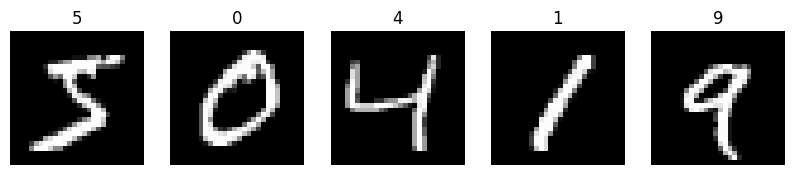

In [3]:
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    img, label = train_data[i]
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()

## 5. Перетворіть навчальні та тестові набори даних MNIST у data loaders за допомогою `torch.utils.data.DataLoader`, встановіть `batch_size=32`.
- Покажіть, яку форму даних вертають дата лоадери.

In [5]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

images, labels = next(iter(train_loader))
print(f"Форма batch: {images.shape}")

Форма batch: torch.Size([32, 1, 28, 28])


## 6. Відтворіть `ModelV2`, яку ми розглядали на лекції
Це до слова та сама модель з [сайту CNN Explainer](https://poloclub.github.io/cnn-explainer/), також відома як TinyVGG і вона здатна навчатися на наборі даних MNIST.

Напишіть клас моделі.

In [7]:
class ModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units*2, hidden_units*2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units*2*7*7, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

model = ModelV2(input_shape=1, hidden_units=10, output_shape=10)

## 7. Навчіть модель, яку ви побудували в попередній вправі, протягом 5 епох на CPU та GPU і подивіться, скільки часу це займе в кожному з варіантів.

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train_model(model, dataloader, loss_fn, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1} | Loss: {total_loss/len(dataloader):.4f}")

start_time = time()
train_model(model, train_loader, loss_fn, optimizer, epochs=5)
print(f"⏱ Час навчання ({device}): {time() - start_time:.2f} секунд")

Epoch 1 | Loss: 0.1839
Epoch 2 | Loss: 0.0581
Epoch 3 | Loss: 0.0443
Epoch 4 | Loss: 0.0359
Epoch 5 | Loss: 0.0299
⏱ Час навчання (cuda): 58.78 секунд


In [10]:
device = "cpu"
model_cpu = ModelV2(input_shape=1, hidden_units=10, output_shape=10).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cpu.parameters(), lr=0.001)

start_time = time()
train_model(model_cpu, train_loader, loss_fn, optimizer, epochs=5)
print(f"⏱ Час навчання ({device}): {time() - start_time:.2f} секунд")

Epoch 1 | Loss: 0.1955
Epoch 2 | Loss: 0.0610
Epoch 3 | Loss: 0.0463
Epoch 4 | Loss: 0.0376
Epoch 5 | Loss: 0.0322
⏱ Час навчання (cpu): 242.86 секунд


## 8. Зробіть прогнози за допомогою вашої навченої моделі та візуалізуйте принаймні 5 з них, порівнюючи прогноз з цільовою міткою.

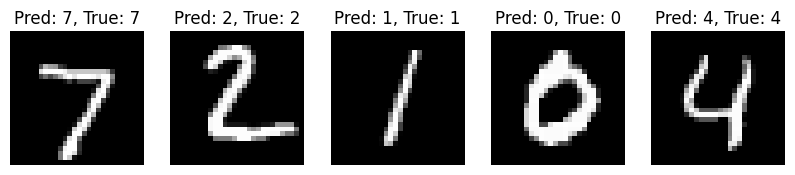

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

model.eval()
X_batch, y_batch = next(iter(test_loader))

with torch.inference_mode():
    X_batch = X_batch.to(device)
    y_pred = model(X_batch).argmax(dim=1).cpu()

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i in range(5):
    axes[i].imshow(X_batch[i].cpu().squeeze(), cmap="gray")
    axes[i].set_title(f"Pred: {y_pred[i]}, True: {y_batch[i]}")
    axes[i].axis("off")
plt.show()

## 9. Побудуйте матрицю плутанини, порівнюючи передбачення вашої моделі з істинними мітками.

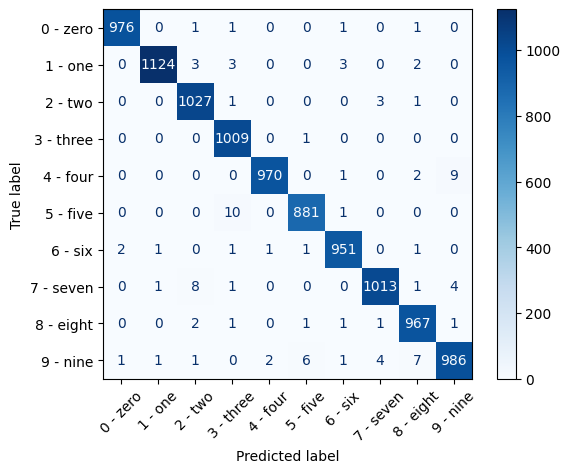

In [16]:
all_preds, all_labels = [], []
model.eval()
with torch.inference_mode():
    for X, y in test_loader:
        preds = model(X.to(device)).argmax(dim=1).cpu()
        all_preds.extend(preds)
        all_labels.extend(y)

cm = confusion_matrix(all_labels, all_preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_data.classes).plot(cmap="Blues", xticks_rotation=45)
plt.show()

## 10. Виведіть принаймні 9 прикладів, де модель помиляється, разом з тим, якою мала бути мітка зображення.
* Після візуалізації цих прогнозів, як ви думаєте, це більше помилка моделювання чи помилка даних?
* Тобто, чи може модель працювати краще, чи мітки даних занадто близькі одна до одної, що навіть людина не може чітко розрізнити що це за цифра?

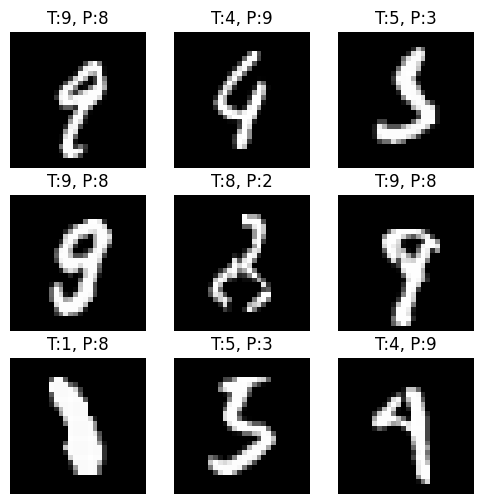

In [19]:
errors = np.where(np.array(all_preds) != np.array(all_labels))[0]

fig, axes = plt.subplots(3, 3, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    idx = errors[i]
    img, true, pred = test_data[idx][0], all_labels[idx], all_preds[idx]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"T:{true}, P:{pred}")
    ax.axis("off")
plt.show()

**Здається, що більшість помилок виникає саме через схожість рукописних цифр, наприклад 5 і 3. Це скоріше обмеження даних, ніж самої моделі.**

## 11. Створіть випадковий тензор форми `[1, 3, 64, 64]` і пропустіть його через шар `nn.Conv2d()` з різними налаштуваннями гіперпараметрів (ви можете вибрати будь-які налаштування), що ви помічаєте, якщо параметр `kernel_size` збільшується або зменшується?

In [20]:
x = torch.randn(1, 3, 64, 64)

conv_small = nn.Conv2d(3, 8, kernel_size=3)
conv_large = nn.Conv2d(3, 8, kernel_size=9)

print("Output (3x3):", conv_small(x).shape)
print("Output (9x9):", conv_large(x).shape)

Output (3x3): torch.Size([1, 8, 62, 62])
Output (9x9): torch.Size([1, 8, 56, 56])


**Якщо збільшити kernel_size, зменшується розмір вихідної карти ознак. Малий kernel кращий для локальних ознак, великий ліпший для глобальних структур.**